# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [64]:
linear_classifer.softmax(np.array([[-5, 0, 5], [5, 1, -5]]))

array([[4.50940412e-05, 6.69254912e-03, 9.93262357e-01],
       [9.81970011e-01, 1.79854081e-02, 4.45813695e-05]])

In [68]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [69]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), np.array([1]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [76]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [77]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [81]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [82]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.393354
Epoch 1, loss: 2.328966
Epoch 2, loss: 2.309817
Epoch 3, loss: 2.304124
Epoch 4, loss: 2.302426
Epoch 5, loss: 2.301922
Epoch 6, loss: 2.301769
Epoch 7, loss: 2.301727
Epoch 8, loss: 2.301713
Epoch 9, loss: 2.301708


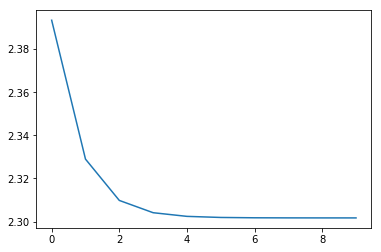

In [83]:
# let's look at the loss history!
plt.plot(loss_history)

In [99]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.116
Epoch 0, loss: 2.301707
Epoch 1, loss: 2.301706
Epoch 2, loss: 2.301709
Epoch 3, loss: 2.301707
Epoch 4, loss: 2.301709
Epoch 5, loss: 2.301708
Epoch 6, loss: 2.301707
Epoch 7, loss: 2.301709
Epoch 8, loss: 2.301708
Epoch 9, loss: 2.301707
Epoch 10, loss: 2.301706
Epoch 11, loss: 2.301707
Epoch 12, loss: 2.301707
Epoch 13, loss: 2.301708
Epoch 14, loss: 2.301708
Epoch 15, loss: 2.301708
Epoch 16, loss: 2.301706
Epoch 17, loss: 2.301709
Epoch 18, loss: 2.301707
Epoch 19, loss: 2.301709
Epoch 20, loss: 2.301707
Epoch 21, loss: 2.301707
Epoch 22, loss: 2.301707
Epoch 23, loss: 2.301708
Epoch 24, loss: 2.301707
Epoch 25, loss: 2.301710
Epoch 26, loss: 2.301709
Epoch 27, loss: 2.301708
Epoch 28, loss: 2.301706
Epoch 29, loss: 2.301708
Epoch 30, loss: 2.301708
Epoch 31, loss: 2.301710
Epoch 32, loss: 2.301707
Epoch 33, loss: 2.301709
Epoch 34, loss: 2.301707
Epoch 35, loss: 2.301709
Epoch 36, loss: 2.301708
Epoch 37, loss: 2.301709
Epoch 38, loss: 2.301706
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [106]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    for reg in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y,
                       epochs=num_epochs,
                       learning_rate=lr,
                       batch_size=batch_size,
                       reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_val_accuracy == None:
            best_classifier = classifier
            best_val_accuracy = accuracy
        if accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.301231
Epoch 1, loss: 2.300241
Epoch 2, loss: 2.299288
Epoch 3, loss: 2.298363
Epoch 4, loss: 2.297457
Epoch 5, loss: 2.296569
Epoch 6, loss: 2.295692
Epoch 7, loss: 2.294828
Epoch 8, loss: 2.293972
Epoch 9, loss: 2.293124
Epoch 10, loss: 2.292286
Epoch 11, loss: 2.291455
Epoch 12, loss: 2.290630
Epoch 13, loss: 2.289813
Epoch 14, loss: 2.289003
Epoch 15, loss: 2.288200
Epoch 16, loss: 2.287403
Epoch 17, loss: 2.286612
Epoch 18, loss: 2.285828
Epoch 19, loss: 2.285050
Epoch 20, loss: 2.284278
Epoch 21, loss: 2.283512
Epoch 22, loss: 2.282752
Epoch 23, loss: 2.281998
Epoch 24, loss: 2.281249
Epoch 25, loss: 2.280506
Epoch 26, loss: 2.279769
Epoch 27, loss: 2.279037
Epoch 28, loss: 2.278310
Epoch 29, loss: 2.277589
Epoch 30, loss: 2.276873
Epoch 31, loss: 2.276162
Epoch 32, loss: 2.275456
Epoch 33, loss: 2.274756
Epoch 34, loss: 2.274060
Epoch 35, loss: 2.273369
Epoch 36, loss: 2.272683
Epoch 37, loss: 2.272002
Epoch 38, loss: 2.271326
Epoch 39, loss: 2.270654
Epoch 40, 

Epoch 124, loss: 2.226576
Epoch 125, loss: 2.226175
Epoch 126, loss: 2.225777
Epoch 127, loss: 2.225381
Epoch 128, loss: 2.224987
Epoch 129, loss: 2.224595
Epoch 130, loss: 2.224206
Epoch 131, loss: 2.223819
Epoch 132, loss: 2.223433
Epoch 133, loss: 2.223050
Epoch 134, loss: 2.222669
Epoch 135, loss: 2.222290
Epoch 136, loss: 2.221912
Epoch 137, loss: 2.221538
Epoch 138, loss: 2.221165
Epoch 139, loss: 2.220794
Epoch 140, loss: 2.220425
Epoch 141, loss: 2.220058
Epoch 142, loss: 2.219693
Epoch 143, loss: 2.219330
Epoch 144, loss: 2.218969
Epoch 145, loss: 2.218610
Epoch 146, loss: 2.218253
Epoch 147, loss: 2.217898
Epoch 148, loss: 2.217544
Epoch 149, loss: 2.217193
Epoch 150, loss: 2.216844
Epoch 151, loss: 2.216496
Epoch 152, loss: 2.216150
Epoch 153, loss: 2.215806
Epoch 154, loss: 2.215464
Epoch 155, loss: 2.215124
Epoch 156, loss: 2.214786
Epoch 157, loss: 2.214449
Epoch 158, loss: 2.214115
Epoch 159, loss: 2.213782
Epoch 160, loss: 2.213450
Epoch 161, loss: 2.213120
Epoch 162, l

Epoch 46, loss: 2.298107
Epoch 47, loss: 2.298015
Epoch 48, loss: 2.297924
Epoch 49, loss: 2.297832
Epoch 50, loss: 2.297741
Epoch 51, loss: 2.297650
Epoch 52, loss: 2.297559
Epoch 53, loss: 2.297469
Epoch 54, loss: 2.297378
Epoch 55, loss: 2.297288
Epoch 56, loss: 2.297198
Epoch 57, loss: 2.297108
Epoch 58, loss: 2.297019
Epoch 59, loss: 2.296929
Epoch 60, loss: 2.296840
Epoch 61, loss: 2.296751
Epoch 62, loss: 2.296662
Epoch 63, loss: 2.296573
Epoch 64, loss: 2.296485
Epoch 65, loss: 2.296396
Epoch 66, loss: 2.296308
Epoch 67, loss: 2.296220
Epoch 68, loss: 2.296132
Epoch 69, loss: 2.296044
Epoch 70, loss: 2.295956
Epoch 71, loss: 2.295868
Epoch 72, loss: 2.295781
Epoch 73, loss: 2.295693
Epoch 74, loss: 2.295606
Epoch 75, loss: 2.295519
Epoch 76, loss: 2.295432
Epoch 77, loss: 2.295345
Epoch 78, loss: 2.295259
Epoch 79, loss: 2.295172
Epoch 80, loss: 2.295085
Epoch 81, loss: 2.294999
Epoch 82, loss: 2.294913
Epoch 83, loss: 2.294827
Epoch 84, loss: 2.294741
Epoch 85, loss: 2.294655


Epoch 168, loss: 2.287916
Epoch 169, loss: 2.287837
Epoch 170, loss: 2.287757
Epoch 171, loss: 2.287678
Epoch 172, loss: 2.287598
Epoch 173, loss: 2.287519
Epoch 174, loss: 2.287440
Epoch 175, loss: 2.287360
Epoch 176, loss: 2.287281
Epoch 177, loss: 2.287202
Epoch 178, loss: 2.287123
Epoch 179, loss: 2.287044
Epoch 180, loss: 2.286965
Epoch 181, loss: 2.286886
Epoch 182, loss: 2.286807
Epoch 183, loss: 2.286728
Epoch 184, loss: 2.286650
Epoch 185, loss: 2.286571
Epoch 186, loss: 2.286493
Epoch 187, loss: 2.286414
Epoch 188, loss: 2.286336
Epoch 189, loss: 2.286257
Epoch 190, loss: 2.286179
Epoch 191, loss: 2.286101
Epoch 192, loss: 2.286022
Epoch 193, loss: 2.285944
Epoch 194, loss: 2.285866
Epoch 195, loss: 2.285788
Epoch 196, loss: 2.285710
Epoch 197, loss: 2.285632
Epoch 198, loss: 2.285554
Epoch 199, loss: 2.285477
Epoch 0, loss: 2.302781
Epoch 1, loss: 2.302664
Epoch 2, loss: 2.302549
Epoch 3, loss: 2.302434
Epoch 4, loss: 2.302321
Epoch 5, loss: 2.302208
Epoch 6, loss: 2.302097


Epoch 92, loss: 2.301413
Epoch 93, loss: 2.301402
Epoch 94, loss: 2.301391
Epoch 95, loss: 2.301380
Epoch 96, loss: 2.301370
Epoch 97, loss: 2.301359
Epoch 98, loss: 2.301348
Epoch 99, loss: 2.301338
Epoch 100, loss: 2.301327
Epoch 101, loss: 2.301316
Epoch 102, loss: 2.301306
Epoch 103, loss: 2.301295
Epoch 104, loss: 2.301284
Epoch 105, loss: 2.301274
Epoch 106, loss: 2.301263
Epoch 107, loss: 2.301253
Epoch 108, loss: 2.301242
Epoch 109, loss: 2.301231
Epoch 110, loss: 2.301221
Epoch 111, loss: 2.301210
Epoch 112, loss: 2.301200
Epoch 113, loss: 2.301189
Epoch 114, loss: 2.301178
Epoch 115, loss: 2.301168
Epoch 116, loss: 2.301157
Epoch 117, loss: 2.301147
Epoch 118, loss: 2.301136
Epoch 119, loss: 2.301126
Epoch 120, loss: 2.301115
Epoch 121, loss: 2.301105
Epoch 122, loss: 2.301094
Epoch 123, loss: 2.301084
Epoch 124, loss: 2.301073
Epoch 125, loss: 2.301063
Epoch 126, loss: 2.301052
Epoch 127, loss: 2.301042
Epoch 128, loss: 2.301031
Epoch 129, loss: 2.301021
Epoch 130, loss: 2.3

Epoch 13, loss: 2.302522
Epoch 14, loss: 2.302511
Epoch 15, loss: 2.302500
Epoch 16, loss: 2.302489
Epoch 17, loss: 2.302477
Epoch 18, loss: 2.302466
Epoch 19, loss: 2.302455
Epoch 20, loss: 2.302444
Epoch 21, loss: 2.302433
Epoch 22, loss: 2.302421
Epoch 23, loss: 2.302410
Epoch 24, loss: 2.302399
Epoch 25, loss: 2.302388
Epoch 26, loss: 2.302377
Epoch 27, loss: 2.302366
Epoch 28, loss: 2.302355
Epoch 29, loss: 2.302344
Epoch 30, loss: 2.302333
Epoch 31, loss: 2.302322
Epoch 32, loss: 2.302311
Epoch 33, loss: 2.302299
Epoch 34, loss: 2.302288
Epoch 35, loss: 2.302277
Epoch 36, loss: 2.302266
Epoch 37, loss: 2.302255
Epoch 38, loss: 2.302244
Epoch 39, loss: 2.302233
Epoch 40, loss: 2.302222
Epoch 41, loss: 2.302211
Epoch 42, loss: 2.302200
Epoch 43, loss: 2.302189
Epoch 44, loss: 2.302179
Epoch 45, loss: 2.302168
Epoch 46, loss: 2.302157
Epoch 47, loss: 2.302146
Epoch 48, loss: 2.302135
Epoch 49, loss: 2.302124
Epoch 50, loss: 2.302113
Epoch 51, loss: 2.302102
Epoch 52, loss: 2.302091


# Какой же точности мы добились на тестовых данных?

In [107]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.196000
